# Analysis and modeling of apartments for sale

## 1. The goal

Analyze the listings and build a model which predicts apartment listing price for the main market segment

---

## 2. Data overview

In [1]:
import pandas

In [2]:
apartments = pandas.read_json("../data/apartments.json")

apartments.info()
apartments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   city       2441 non-null   object 
 1   rooms      2470 non-null   object 
 2   area_m2    2468 non-null   float64
 3   price_eur  2470 non-null   int64  
 4   listed_by  2470 non-null   object 
 5   condition  1957 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 115.9+ KB


,city,rooms,area_m2,price_eur,listed_by,condition
0,Ilidža,2,47.12,73224,shop,used
1,Sarajevo - Centar,1,32.00,76923,shop,used
2,Sarajevo - Novo Sarajevo,2,53.00,125641,shop,used
3,Sarajevo - Stari Grad,1,34.00,92308,shop,used
4,Sarajevo - Centar,4,113.00,171795,shop,used


---

## 3. Data cleaning

### 3.1. Missing values

In [3]:
total_rows             = apartments.shape[0]
missing_counts_by_row  = apartments.isna().sum()
nonzero_missing_counts = missing_counts_by_row[missing_counts_by_row > 0]

print("Percent of rows missing")
print(round(100 * nonzero_missing_counts / total_rows, 1))

Percent of rows missing
city          1.2
area_m2       0.1
condition    20.8
dtype: float64


In [4]:
# Drop rows missing city and apartment size, since there are very few of them
apartments = apartments.dropna(subset=["city", "area_m2"])

# Replace empty apartment conditions with "unknown"
apartments = apartments.fillna("unknown")


new_total_rows    = apartments.shape[0]
percent_remaining = round(100 * new_total_rows / total_rows, 1)

print(f"{percent_remaining}% of original rows remain after handling missing values")

98.7% of original rows remain after handling missing values


### 3.2. Incorrect values

In [5]:
print("Smallest apartments")
apartments.sort_values(by="area_m2").head(3)

Smallest apartments


,city,rooms,area_m2,price_eur,listed_by,condition
904,Ilidža,5+,1.132,512821,shop,new
2467,Vogošća,studio,13.800,25897,user,new
2160,Zenica,studio,16.000,34872,shop,used


In [6]:
# Drop the "smallest" apartment (could be 1132 m², but this is safer)
apartments = apartments.drop(904)

In [7]:
print("\nLargest apartments")
apartments.sort_values(by="area_m2", ascending=False).head(3)


Largest apartments


,city,rooms,area_m2,price_eur,listed_by,condition
1637,Mostar,2,10579.0,220513,shop,used
2124,Sarajevo - Novi Grad,2,800.0,410256,user,used
1902,Sarajevo - Novo Sarajevo,5+,560.0,676923,user,used


In [8]:
# Drop the largest "apartment" (at 10k m², this is a whole building)
apartments = apartments.drop(1637)

In [9]:
low_end_price_segments = pandas.cut(
    apartments.query("price_eur < 10_000").price_eur,
    bins=[0, 2_000, 4_000, 6_000, 8_000, 10_000]
)

print("Cheap listings counts by price segment")
low_end_price_segments.value_counts().sort_index()

Cheap listings counts by price segment


price_eur
(0, 2000]        20
(2000, 4000]      6
(4000, 6000]      0
(6000, 8000]      0
(8000, 10000]     1
Name: count, dtype: int64

In [10]:
# Drop all listings with prices bellow 5_000, since they"re not realistic,
# and are probably coming from wrong listing type (should be for rent),
# or wrong price kind (per m² instead of total),
# while making up a very small portion of all listings
apartments = apartments[apartments.price_eur > 5_000]


new_total_rows    = apartments.shape[0]
percent_remaining = round(100 * new_total_rows / total_rows, 1)

print(f"{percent_remaining}% of original rows remain after handling bad values")

97.6% of original rows remain after handling bad values


### 3.3. Duplicated values

In [11]:
print("Total duplicated rows:", apartments[apartments.duplicated()].shape[0])

Total duplicated rows: 117


In [12]:
# Drop duplicated rows, since there isn"t that many of them
apartments = apartments.drop_duplicates()

new_total_rows    = apartments.shape[0]
percent_remaining = round(100 * new_total_rows / total_rows, 1)

print(f"{percent_remaining}% of original rows remain after handling bad values")

92.9% of original rows remain after handling bad values


### 3.4. Data selection

While the data is clean at this point, it has a lot of extreme values.  
We"ll focus on the main segment of the market covering 98% of the size and price ranges.

In [13]:
MIN_AREA  = round(apartments.area_m2.quantile(0.01))
MAX_AREA  = round(apartments.area_m2.quantile(0.99))
MIN_PRICE = int(round(apartments.price_eur.quantile(0.01), -3))
MAX_PRICE = int(round(apartments.price_eur.quantile(0.99), -3))


apartments = apartments[
    ((apartments.area_m2   >= MIN_AREA)  & (apartments.area_m2   <= MAX_AREA))
  & ((apartments.price_eur >= MIN_PRICE) & (apartments.price_eur <= MAX_PRICE))
]
new_total_rows    = apartments.shape[0]
percent_remaining = round(100 * new_total_rows / total_rows, 1)

print(
  f"{percent_remaining}% of original rows remain after applying "
  "the following constraints:"
)
print(f"Size range: {MIN_AREA} to {MAX_AREA} m²")
print(f"Price range: {MIN_PRICE} to {MAX_PRICE} €")

89.8% of original rows remain after applying the following constraints:
Size range: 26 to 162 m²
Price range: 28000 to 435000 €


### 3.5. Data formatting

In [14]:
# Convert object values to categories
apartments.city      = apartments.city.astype("category")
apartments.rooms     = apartments.rooms.astype("category")
apartments.listed_by = apartments.listed_by.astype("category")
apartments.condition = apartments.condition.astype("category")

print("\nFinal dataset after data cleaning:\n")
apartments.info()


Final dataset after data cleaning:

<class 'pandas.core.frame.DataFrame'>
Index: 2217 entries, 0 to 2469
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   city       2217 non-null   category
 1   rooms      2217 non-null   category
 2   area_m2    2217 non-null   float64 
 3   price_eur  2217 non-null   int64   
 4   listed_by  2217 non-null   category
 5   condition  2217 non-null   category
dtypes: category(4), float64(1), int64(1)
memory usage: 63.9 KB


---

## 4. Data exploration

In [15]:
import seaborn
from matplotlib import pyplot

seaborn.set_theme(style="darkgrid")

### 4.1. Univariate

#### 4.1.1. Categorical variables

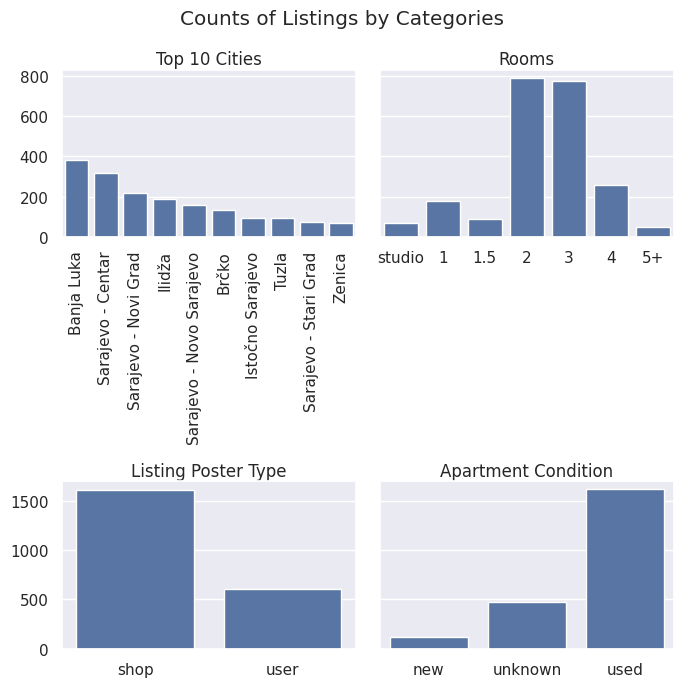

In [16]:
rooms_order_by_size = ["studio", "1", "1.5", "2", "3", "4", "5+"]
most_popular_cities = apartments.city.value_counts().head(10).index


figure, axes = pyplot.subplots(ncols=2, nrows=2, sharey="row", figsize=(7, 7))

cities_plot = seaborn.countplot(
    data=apartments,
    x="city",
    order=most_popular_cities,
    ax=axes[0,0]
)
cities_plot.set_xlabel("Top 10 Cities")
cities_plot.xaxis.set_label_position("top")
cities_plot.tick_params(axis="x", rotation=90)
cities_plot.set_ylabel(None)

rooms_plot = seaborn.countplot(
    data=apartments,
    x="rooms",
    order=rooms_order_by_size,
    ax=axes[0,1]
)
rooms_plot.set_xlabel("Rooms")
rooms_plot.xaxis.set_label_position("top")
rooms_plot.set_ylabel(None)


poster_plot = seaborn.countplot(
    data=apartments,
    x="listed_by",
    ax=axes[1,0]
)
poster_plot.set_xlabel("Listing Poster Type")
poster_plot.xaxis.set_label_position("top")
poster_plot.set_ylabel(None)

condition_plot = seaborn.countplot(
    data=apartments,
    x="condition",
    ax=axes[1,1]
)
condition_plot.set_xlabel("Apartment Condition")
condition_plot.xaxis.set_label_position("top")
condition_plot.set_ylabel(None)

figure.suptitle("Counts of Listings by Categories");
figure.tight_layout()

#### 4.1.2. Numerical variables

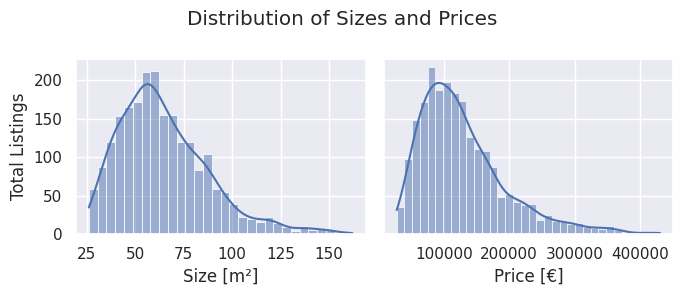

In [17]:
figure, axes = pyplot.subplots(ncols=2, figsize=(7, 3), sharey=True)

size_plot = seaborn.histplot(
    data=apartments,
    x="area_m2",
    kde=True,
    ax=axes[0]
)
size_plot.set_xlabel("Size [m²]")
size_plot.set_ylabel("Total Listings")

price_plot = seaborn.histplot(
    data=apartments,
    x="price_eur",
    kde=True,
    ax=axes[1]
)
price_plot.set_xlabel("Price [€]")

figure.suptitle("Distribution of Sizes and Prices")
figure.tight_layout()

### 4.2. Multivariate

#### 4.2.1. Price vs. size

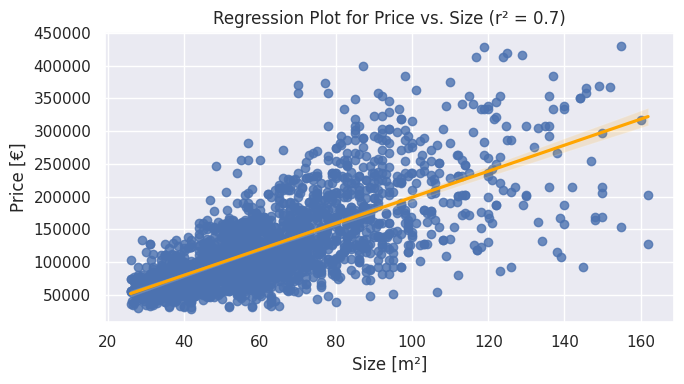

In [18]:
size_price_r2 = round(apartments[["area_m2", "price_eur"]].corr().iloc[0,1], 2)

size_price_plot = seaborn.regplot(
    data=apartments,
    x="area_m2",
    y="price_eur",
    line_kws={"color":"orange"}
)
size_price_plot.title.set_text(
    f"Regression Plot for Price vs. Size (r² = {size_price_r2})"
)
size_price_plot.set_xlabel("Size [m²]")
size_price_plot.set_ylabel("Price [€]")
size_price_plot.figure.set_size_inches(7, 4)
size_price_plot.figure.tight_layout()

#### 4.2.2. Size and Price across Categories

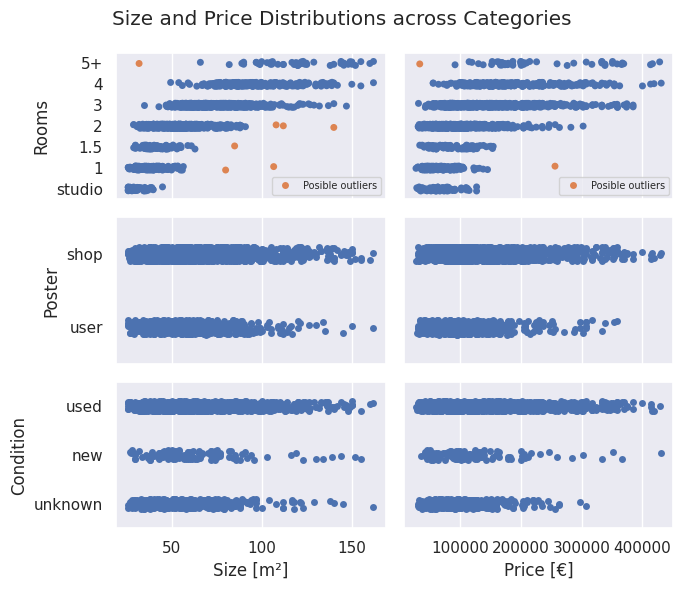

In [19]:
# Possible outliers, not representative of their room categories,
# - can be seen marked orange in the plot below
room_area_outliers = apartments.loc[
    ((apartments.rooms == "5+")  & (apartments.area_m2 < 50))
  | ((apartments.rooms == "2")   & (apartments.area_m2 > 100))
  | ((apartments.rooms == "1.5") & (apartments.area_m2 > 75))
  | ((apartments.rooms == "1")   & (apartments.area_m2 > 75))
]
room_price_outliers = apartments.loc[
    ((apartments.rooms == "5+") & (apartments.price_eur < 75_000))
  | ((apartments.rooms == "1")  & (apartments.price_eur > 200_000))
]


figure, axes = pyplot.subplots(
    ncols=2,
    nrows=3,
    sharex="col",
    sharey="row",
    figsize=(7, 6)
)

area_rooms_plot = seaborn.stripplot(
    data=apartments,
    x="area_m2",
    y="rooms",
    hue=apartments.index.isin(room_area_outliers.index),
    order=list(reversed(rooms_order_by_size)),
    ax=axes[0,0]
)
area_rooms_plot.set_ylabel("Rooms")
handles, labels = area_rooms_plot.get_legend_handles_labels()
area_rooms_plot.legend(
    handles=[handles[1]],
    labels=["Posible outliers"],
    fontsize=7
)

area_poster_plot = seaborn.stripplot(
    data=apartments,
    x="area_m2",
    y="listed_by",
    ax=axes[1,0]
)
area_poster_plot.set_ylabel("Poster")

area_condition_plot = seaborn.stripplot(
    data=apartments,
    x="area_m2",
    y="condition",
    order=(
        apartments.groupby("condition", observed=False)
            ["area_m2"].median()
        .sort_values(ascending=False).index
    ),
    ax=axes[2,0]
)
area_condition_plot.set_xlabel("Size [m²]")
area_condition_plot.set_ylabel("Condition")

price_rooms_plot = seaborn.stripplot(
    data=apartments,
    x="price_eur",
    y="rooms",
    hue=apartments.index.isin(room_price_outliers.index),
    order=list(reversed(rooms_order_by_size)),
    ax=axes[0,1]
)
handles, labels = price_rooms_plot.get_legend_handles_labels()
price_rooms_plot.legend(
    handles=[handles[1]],
    labels=["Posible outliers"],
    fontsize=7
)

seaborn.stripplot(
    data=apartments,
    x="price_eur",
    y="listed_by",
    ax=axes[1,1]
)
price_condition_plot = seaborn.stripplot(
    data=apartments,
    x="price_eur",
    y="condition",
    order=(
        apartments.groupby("condition", observed=False)
            ["price_eur"].median()
            .sort_values(ascending=False).index
    ),
    ax=axes[2,1]
)
price_condition_plot.set_xlabel("Price [€]")

figure.suptitle("Size and Price Distributions across Categories")
figure.tight_layout()

#### 4.2.3. Size and Price across Popular Cities

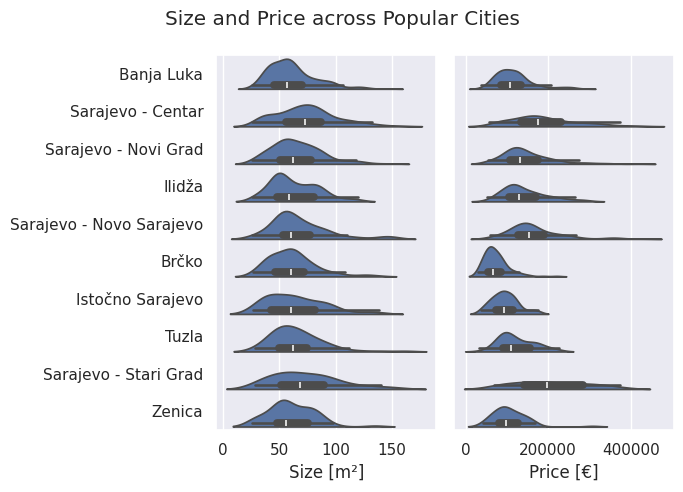

In [20]:
figure, axes = pyplot.subplots(ncols=2, sharey=True, figsize=(7, 5))

area_plot = seaborn.violinplot(
    data=apartments,
    y="city",
    x="area_m2",
    order=most_popular_cities,
    split=True,
    ax=axes[0]
)
area_plot.set_xlabel("Size [m²]")
area_plot.set_ylabel(None)

price_plot = seaborn.violinplot(
    data=apartments,
    y="city",
    x="price_eur",
    order=most_popular_cities,
    split=True,
    ax=axes[1]
)
price_plot.set_xlabel("Price [€]")

figure.suptitle("Size and Price across Popular Cities")
figure.tight_layout()

---

## 5. Modeling

In [21]:
y = apartments.price_eur
X = apartments.drop(columns=["price_eur"])

### 5.1. Model selection and scoring

We'll use three models: linear regression, random forest, and gradient boosting.  
We'll define a helper function that displays the score for the pipelines

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline        import Pipeline


def score_models(X, models, preprocessors):
    pipelines = [
        (
            models[i]["name"],
            Pipeline(steps=[
                ("preprocessor", preprocessors[i]),
                ("model", models[i]["model"])
            ])
        )
        for i in range(len(models))
    ]

    models = []
    maes   = []
    r2s    = []
    for name, pipeline in pipelines:
        mae_score = cross_val_score(
            pipeline, cv=3, scoring="neg_mean_absolute_error",
            X=X, y=y, error_score="raise"
        ).mean()
        mae = int(round(-mae_score, -1))

        r2_score = cross_val_score(
            pipeline, cv=3, scoring="r2",
            X=X, y=y, error_score="raise"
        ).mean()
        r2  = round(r2_score, 3)
        
        models.append(name)
        maes.append(mae)
        r2s.append(r2)

    return pandas.DataFrame(
        {"MAE": maes, "R²": r2s},
        index=models
    )

### 5.2. Baseline

In [23]:
from warnings              import filterwarnings
from sklearn.linear_model  import LinearRegression
from sklearn.ensemble      import RandomForestRegressor
from xgboost               import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose       import ColumnTransformer


filterwarnings("ignore")
RANDOM_STATE = 0

baseline_models = [
    {"name": "Baseline Linear Regression", "model": LinearRegression()},
    {"name": "Baseline Random Forest", "model": RandomForestRegressor(random_state=RANDOM_STATE)},
    {"name": "Baseline Gradient Boost", "model": XGBRegressor(random_state=RANDOM_STATE)},
]
baseline_preprocessors = [
    ColumnTransformer(transformers=[
        ("city", OneHotEncoder(handle_unknown="ignore"), ["city"]),
        ("rooms", OneHotEncoder(handle_unknown="ignore"), ["rooms"]),
        ("area_m2", StandardScaler(), ["area_m2"]),
        ("listed_by", OneHotEncoder(handle_unknown="ignore"), ["listed_by"]),
        ("condition", OneHotEncoder(handle_unknown="ignore"), ["condition"]),
    ])
    for _ in range(3)
]
X = apartments.drop(columns=["price_eur"])

baseline_scores = score_models(
    X,
    baseline_models,
    baseline_preprocessors
)
baseline_scores

,MAE,R²
Baseline Linear Regression,26170,0.694
Baseline Random Forest,25200,0.686
Baseline Gradient Boost,24950,0.693


### 5.3. Feature engineering

In [24]:
X_fe = X.copy()

X_fe["is_in_popular_city"] = X_fe.city.isin(most_popular_cities.to_list()[:10])
X_fe["is_premium"] = (
    (X_fe.is_in_popular_city)
  & (X_fe.rooms.isin(["3", "4", "5+"]))
)

models_fe = [
    {
        "name": "Baseline Linear Regression + FE",
        "model": LinearRegression()
    },
    {
        "name": "Baseline Random Forest + FE",
        "model": RandomForestRegressor(random_state=RANDOM_STATE)
    },
    {
        "name": "Baseline Gradient Boost + FE",
        "model": XGBRegressor(random_state=RANDOM_STATE)
    },
]
preprocessors_fe = [
    ColumnTransformer(transformers=[
        # Baseline transformers
        ("city", OneHotEncoder(handle_unknown="ignore"), ["city"]),
        ("rooms", OneHotEncoder(handle_unknown="ignore"), ["rooms"]),
        ("area_m2", StandardScaler(), ["area_m2"]),
        ("listed_by", OneHotEncoder(handle_unknown="ignore"), ["listed_by"]),
        ("condition", OneHotEncoder(handle_unknown="ignore"), ["condition"]),

        # New columns
        ("is_in_popular_city", "passthrough", ["is_in_popular_city"]),
        ("is_premium", "passthrough", ["is_premium"]),
    ])
    for _ in range(3)
]

fe_scores = score_models(
    X_fe,
    models_fe,
    preprocessors_fe
)
fe_scores

,MAE,R²
Baseline Linear Regression + FE,25950,0.699
Baseline Random Forest + FE,24820,0.694
Baseline Gradient Boost + FE,24440,0.703


### 5.4. Parameter tuning

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing   import OrdinalEncoder, MinMaxScaler

#### 5.4.1. Random Forest

In [26]:
# Baseline pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessors_fe[1]),      
    ("model", baseline_models[1]["model"])
])


cities_by_popularity = apartments.city.value_counts().index.to_list()

# Pipeline parameter variations
parameter_variations = {
    "preprocessor__city" : [
        OneHotEncoder(handle_unknown="ignore"),

        # Order by city popularity
        OrdinalEncoder(categories=[cities_by_popularity])
    ],
    "preprocessor__rooms" : [
        OneHotEncoder(handle_unknown="ignore"),

        # Order by room size
        OrdinalEncoder(categories=[rooms_order_by_size])
    ],
    "preprocessor__area_m2" : [
        "passthrough",
        StandardScaler(),
        MinMaxScaler()
    ],
    "preprocessor__listed_by" : [
        OneHotEncoder(handle_unknown="ignore"),

        # Prefer one over the other type of poster
        OrdinalEncoder(categories=[["user", "shop"]]),
        OrdinalEncoder(categories=[["shop", "user"]])
    ],
    "preprocessor__condition" : [
        OneHotEncoder(handle_unknown="ignore"),

        # Prefer apartment states
        OrdinalEncoder(categories=[["uknown", "used", "new"]]),
        OrdinalEncoder(categories=[["uknown", "new", "used"]]),
        OrdinalEncoder(categories=[["new", "unknown", "used"]]),
        OrdinalEncoder(categories=[["new", "used", "unknown"]]),
        OrdinalEncoder(categories=[["used", "new", "unknown"]]),
        OrdinalEncoder(categories=[["used", "unknown", "new"]])
    ],

    "model__n_estimators"     : [100, 200, 300, 500, 1_000],
    "model__max_depth"        : [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf" : [1, 2, 5, 10],
    "model__max_features"     : ["sqrt", "log2", None, "auto", 5, 10]
}

random_search = RandomizedSearchCV(
    random_state=RANDOM_STATE,
    estimator=pipeline,
    param_distributions=parameter_variations,
    cv=3,
    n_jobs=-1,
    n_iter=200,
    verbose=1,
    scoring="neg_mean_absolute_error"
)
random_search.fit(X_fe, y)
print("Best parameters:")
random_search.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters:


{'preprocessor__rooms': OrdinalEncoder(categories=[['studio', '1', '1.5', '2', '3', '4', '5+']]),
 'preprocessor__listed_by': OrdinalEncoder(categories=[['user', 'shop']]),
 'preprocessor__condition': OneHotEncoder(handle_unknown='ignore'),
 'preprocessor__city': OneHotEncoder(handle_unknown='ignore'),
 'preprocessor__area_m2': StandardScaler(),
 'model__n_estimators': 200,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 1,
 'model__max_features': None,
 'model__max_depth': 30}

#### 5.4.2. Gradient Boost

In [27]:
# Baseline pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", baseline_preprocessors[2]),      
    ("model", baseline_models[2]["model"])
])


# Pipeline parameter variations
parameter_variations = {
    "preprocessor__city" : [
        OneHotEncoder(handle_unknown="ignore"),

        # Order by city popularity
        OrdinalEncoder(categories=[cities_by_popularity])
    ],
    "preprocessor__rooms" : [
        OneHotEncoder(handle_unknown="ignore"),

        # Order by room size
        OrdinalEncoder(categories=[rooms_order_by_size])
    ],
    "preprocessor__area_m2" : [
        "passthrough",
        StandardScaler(),
        MinMaxScaler()
    ],
    "preprocessor__listed_by" : [
        OneHotEncoder(handle_unknown="ignore"),

        # Prefer one over the other type of poster
        OrdinalEncoder(categories=[["user", "shop"]]),
        OrdinalEncoder(categories=[["shop", "user"]])
    ],
    "preprocessor__condition" : [
        OneHotEncoder(handle_unknown="ignore"),

        # Prefer apartment states
        OrdinalEncoder(categories=[["uknown", "used", "new"]]),
        OrdinalEncoder(categories=[["uknown", "new", "used"]]),
        OrdinalEncoder(categories=[["new", "unknown", "used"]]),
        OrdinalEncoder(categories=[["new", "used", "unknown"]]),
        OrdinalEncoder(categories=[["used", "new", "unknown"]]),
        OrdinalEncoder(categories=[["used", "unknown", "new"]])
    ],

    "model__n_estimators"    : [100, 200, 500, 1_000],
    "model__learning_rate"   : [0.01, 0.05, 0.1],
    "model__max_depth"       : [2, 5, 10],
    "model__min_child_weight": [1, 3, 5],
    "model__subsample"       : [0.25, 0.5, 1.0],
    "model__colsample_bytree": [0.25, 0.5, 1.0],
    "model__gamma"           : [0, 0.3, 0.6],
}

random_search = RandomizedSearchCV(
    random_state=RANDOM_STATE,
    estimator=pipeline,
    param_distributions=parameter_variations,
    cv=3,
    n_jobs=-1,
    n_iter=200,
    verbose=1,
    scoring="neg_mean_absolute_error"
)
random_search.fit(X_fe, y)
print("Best parameters:")
random_search.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters:


{'preprocessor__rooms': OrdinalEncoder(categories=[['studio', '1', '1.5', '2', '3', '4', '5+']]),
 'preprocessor__listed_by': OrdinalEncoder(categories=[['shop', 'user']]),
 'preprocessor__condition': OneHotEncoder(handle_unknown='ignore'),
 'preprocessor__city': OrdinalEncoder(categories=[['Banja Luka', 'Sarajevo - Centar',
                             'Sarajevo - Novi Grad', 'Ilidža',
                             'Sarajevo - Novo Sarajevo', 'Brčko',
                             'Istočno Sarajevo', 'Tuzla',
                             'Sarajevo - Stari Grad', 'Zenica', 'Bijeljina',
                             'Vogošća', 'Pale', 'Mostar', 'Istočna Ilidža',
                             'Trebinje', 'Doboj', 'Prijedor', 'Lukavac',
                             'Gradiška', 'Živinice', 'Bihać', 'Ljubuški',
                             'Visoko', 'Cazin', 'Laktaši', 'Travnik', 'Tešanj',
                             'Čelinac', 'Trnovo', ...]]),
 'preprocessor__area_m2': MinMaxScaler(),
 'mode

#### 5.4.3. Tuned scores

In [28]:
tuned_forest_model = {
    "name": "Tuned Random Forest + FE",
    "model": RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features=None,
        max_depth=30
    )
}
tuned_forest_preprocessor = ColumnTransformer(transformers=[
    ("city", OneHotEncoder(handle_unknown="ignore"), ["city"]),
    ("rooms", OrdinalEncoder(categories=[rooms_order_by_size]), ["rooms"]),
    ("area_m2", StandardScaler(), ["area_m2"]),
    ("listed_by", OrdinalEncoder(categories=[['user', 'shop']]), ["listed_by"]),
    ("condition", OneHotEncoder(handle_unknown='ignore'), ["condition"]),
])

tuned_boost_model = {
    "name": "Tuned Gradient Boost + FE",
    "model": XGBRegressor(
        random_state=RANDOM_STATE,
        subsample=0.5,
        n_estimators=1_000,
        min_child_weight=3,
        max_depth=5,
        learning_rate=0.01,
        gamma=0.3,
        colsample_bytree=1.0
    )
}
tuned_boost_preprocessor = ColumnTransformer(transformers=[
    ("city", OrdinalEncoder(categories=[cities_by_popularity]), ["city"]),
    ("rooms", OrdinalEncoder(categories=[rooms_order_by_size]), ["rooms"]),
    ("area_m2", MinMaxScaler(), ["area_m2"]),
    ("listed_by", OrdinalEncoder(categories=[['shop', 'user']]), ["listed_by"]),
    ("condition", OneHotEncoder(handle_unknown='ignore'), ["condition"]),
])

tuned_scores = score_models(
    X_fe,
    [tuned_forest_model,        tuned_boost_model],
    [tuned_forest_preprocessor, tuned_boost_preprocessor]
)

### 5.5. Results comparison

In [29]:
baseline_scores

,MAE,R²
Baseline Linear Regression,26170,0.694
Baseline Random Forest,25200,0.686
Baseline Gradient Boost,24950,0.693


In [30]:
fe_scores

,MAE,R²
Baseline Linear Regression + FE,25950,0.699
Baseline Random Forest + FE,24820,0.694
Baseline Gradient Boost + FE,24440,0.703


In [31]:
tuned_scores

,MAE,R²
Tuned Random Forest + FE,24200,0.713
Tuned Gradient Boost + FE,24370,0.712


---

## 6. Possible improvements

- More/better engineered features
- Further outliers removal
- More exhaustive parameter optimization (Grid search)